In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
sns.set(rc={'figure.figsize':(12,8)})
%matplotlib inline
import geopandas as gpd

In [2]:
presc = pd.read_csv('../data_prep/depression_V4.csv.gz', compression='gzip')
wards = pd.read_csv('../data_prep/Wards.csv')

In [3]:
presc.head(n=5)

,YYYYMM,LSOA_CODE,Total_quantity,Dosage_ratio,Total_cost,Total_items,Patient_count
0,201901,E01012190,5528.443524,28890.507539,325.828615,144.748521,1414.0
1,201901,E01012191,6304.076418,33211.748735,371.863143,165.890416,1618.0
2,201901,E01012192,5980.935350,32829.680515,350.484745,150.165290,1511.0
3,201901,E01012194,5704.954893,31238.477543,335.243875,143.202664,1480.0
4,201901,E01012195,6256.477717,34736.725948,367.127907,157.295769,1624.0


In [4]:
wards.head(n=2)

,Unnamed: 0,LSOA11CD,WD15CD,WD15NM,LAD15CD,LocalAuthorityName,CityName,Area Codes,All Ages
0,0,E01000104,E05000041,Village,E09000002,Barking and Dagenham,London,E01000104,1811
1,1,E01000105,E05000041,Village,E09000002,Barking and Dagenham,London,E01000105,2349


In [5]:
presc_merged = pd.merge(presc,wards,left_on='LSOA_CODE' , right_on='LSOA11CD')

In [6]:
len(presc_merged), len(presc)

(393996, 393996)

In [16]:
from tqdm import tqdm
LAD_dict = {'LADCD':[], 'mean_cost':[] , 'mean_items' : [] , 'mean_quantity' : []}
for name , group in tqdm(presc_merged.groupby('LAD15CD')):
    LAD_dict['LADCD'].append(name)
    LAD_dict['mean_cost'].append((np.sum(group['Total_cost'])/group.iloc[1]['Patient_count'])*1000)
    LAD_dict['mean_items'].append((np.sum(group['Total_items'])/group.iloc[1]['Patient_count'])*1000)
    LAD_dict['mean_quantity'].append((np.sum(group['Total_items'])/group.iloc[1]['Patient_count'])*1000)
LAD_df = pd.DataFrame.from_dict(LAD_dict)

100%|██████████| 326/326 [00:00<00:00, 665.01it/s]


In [17]:
LAD_df

,LADCD,mean_cost,mean_items,mean_quantity
0,E06000001,79363.944846,31877.824789,31877.824789
1,E06000002,77070.071879,36677.276555,36677.276555
2,E06000003,281614.410944,123572.441197,123572.441197
3,E06000004,323586.338956,147355.503553,147355.503553
4,E06000005,144156.761043,72844.750446,72844.750446
...,...,...,...,...
321,E09000029,196444.610284,80651.015094,80651.015094
322,E09000030,52396.388579,23393.169672,23393.169672
323,E09000031,190089.286793,60189.406858,60189.406858
324,E09000032,223001.324232,58034.050378,58034.050378


In [18]:
lad_boundries = gpd.read_file('../data_prep/geography/Local_Authority_Districts_(December_2015)_Boundaries.shp')

In [19]:
lad_boundries.head(n=2)

,objectid,lad15cd,lad15nm,lad15nmw,st_areasha,st_lengths,geometry
0,1,E06000001,Hartlepool,None,9.357532e+07,71948.370595,"MULTIPOLYGON (((447213.900 537036.100, 447228...."
1,2,E06000002,Middlesbrough,None,5.388858e+07,43840.978347,"MULTIPOLYGON (((448958.900 521835.700, 449045...."


In [20]:
LAD_merged = pd.merge(LAD_df , lad_boundries , left_on='LADCD', right_on='lad15cd')

In [21]:
len(LAD_merged)

326

In [22]:
LAD_merged_gdf = gpd.GeoDataFrame(LAD_merged)

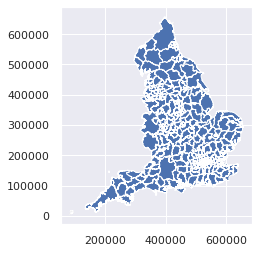

In [23]:
LAD_merged_gdf.plot()

In [29]:
LAD_merged_gdf.sort_values(by='mean_items',inplace=True)

In [30]:
LAD_merged_gdf.head(n=3)

,LADCD,mean_cost,mean_items,mean_quantity,objectid,lad15cd,lad15nm,lad15nmw,st_areasha,st_lengths,geometry
293,E09000001,394.793979,86.551597,86.551597,294,E09000001,City of London,None,2.903922e+06,9249.687136,"POLYGON ((532140.300 182191.900, 532141.500 18..."
51,E06000053,668.527969,546.444389,546.444389,52,E06000053,Isles of Scilly,None,1.637465e+07,116109.745423,"MULTIPOLYGON (((91728.700 12925.300, 91732.100..."
312,E09000020,20745.510668,4959.402743,4959.402743,313,E09000020,Kensington and Chelsea,None,1.212385e+07,20973.827399,"POLYGON ((523033.500 182739.200, 523042.400 18..."


In [36]:
LAD_merged_gdf_top10 = LAD_merged_gdf[-10:]

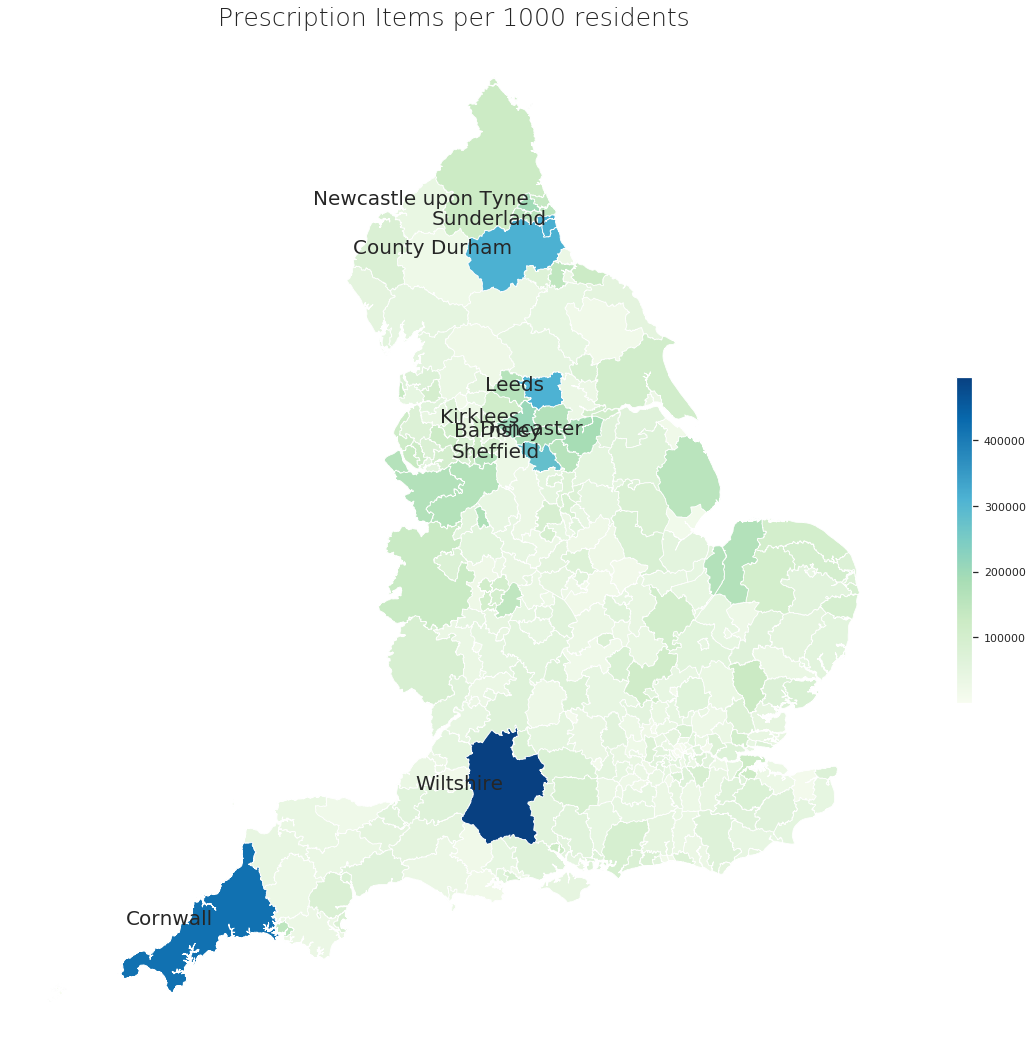

In [37]:
fig, ax = plt.subplots()
fig.set_size_inches(20,20)
ax.axis('off')
ax.set_title('Prescription Items per 1000 residents', fontdict={'fontsize': '25', 'fontweight' : '5'})
sm = plt.cm.ScalarMappable(cmap='GnBu', norm=plt.Normalize(vmin=LAD_merged_gdf['mean_items'].min(), vmax=LAD_merged_gdf['mean_items'].max()))
#empty array for the data range
sm._A = []
#add the colorbar to the figure
cbar = fig.colorbar(sm,shrink=0.3)
LAD_merged_gdf.plot(ax=ax,column='mean_items', cmap='GnBu', linewidth=0.8)
LAD_merged_gdf_top10.apply(lambda x: ax.annotate(s=x.lad15nm, xy=x.geometry.centroid.coords[0], ha='right',fontsize=20),axis=1);